In [77]:
import numpy as np
import pandas as pd
import librosa
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

DIR_DATASET = "./ec10_subsampled/"

# Parâmetros de Análise Espectral
TAXA_AMOSTRAGEM = 44100
TAM_JANELA = 1024
PASSO_JANELA = 256
N_MELS = 128
N_MFCC = 30

In [78]:
def extrair_caracteristicas(arquivo_audio,
                            taxa_amostragem=44100,
                            tam_janela=1024,
                            passo_janela=512,
                            mono=True,
                            n_mfcc=20,
                            n_mels=128,
                            silence_threhold_percentile=None):
    parametros_fft = {
        'n_fft': tam_janela,
        'hop_length': passo_janela
    }
    # Abre o arquivo de Áudio
    y, sr = librosa.load(arquivo_audio, sr=taxa_amostragem, mono=mono)

    # Calcula o Mel Espectrograma
    MS = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, **parametros_fft)

    # Calcula as características espectrais
    centroid = librosa.feature.spectral_centroid(S=MS, **parametros_fft)
    rolloff = librosa.feature.spectral_rolloff(S=MS, roll_percent=0.85, **parametros_fft)
    flatness = librosa.feature.spectral_flatness(S=MS, **parametros_fft)
    contrast = librosa.feature.spectral_contrast(S=MS, **parametros_fft)
    rms = librosa.feature.rms(y=y, frame_length=tam_janela, hop_length=passo_janela)

    if silence_threhold_percentile is not None:
        # Elimina frames silenciosos com base no RMS
        percentil = np.percentile(rms, silence_threhold_percentile)
        frames_interesse = rms > percentil
        # Aplica a máscara de frames silenciosos
        MS = MS[:,frames_interesse.flatten()]


    # Calcula os MFCCs
    mfccs = librosa.feature.mfcc(S=MS, n_mfcc=n_mfcc)

    # Calcula a Taxa de Cruzamento por Zero (domínio do tempo)
    zcr = librosa.feature.zero_crossing_rate(y=y, frame_length=tam_janela,
                                             hop_length=passo_janela)

    # Calcula as médias de cada característica ao longo do tempo
    medias = list(map(np.mean, [centroid, rolloff, flatness, contrast, zcr, rms]))
    stds = list(map(np.std, [centroid, rolloff, flatness, contrast, zcr, rms])) # Desvio Padrão

    #print(medias.shape, skews.shape, kurt.shape)
    # Calcula a média dos MFCCs ao longo do tempo.
    # axis=1 indica que a média é calculada ao longo das colunas (tempo).
    # Isto é necessário com os MFCCs, pois temos mais de um coeficiente por frame.
    medias_mfcc = np.mean(mfccs, axis=1)
    stds_mfcc = np.std(mfccs, axis=1)

    # Combinar todas as características em um único vetor
    features = np.concatenate([medias, medias_mfcc, stds, stds_mfcc])

    return features

def extrair_caracteristicas_lista(lista_arquivos, caminho, params_caracteristicas):
    X = []

    # Extrair características de cada gravação usando a função extrair_caracteristicas
    for arquivo in lista_arquivos:
        caracteristicas = extrair_caracteristicas(caminho + arquivo, **params_caracteristicas)
        X.append(caracteristicas)

    # Converte a lista de vetores em um array numpy (matriz)
    return np.array(X)


In [79]:
params_caracteristicas = {
    'taxa_amostragem': TAXA_AMOSTRAGEM,
    'tam_janela': TAM_JANELA,
    'passo_janela': PASSO_JANELA,
    'n_mels': N_MELS,
    'n_mfcc': N_MFCC,
    'silence_threhold_percentile': 10
}

# Carregar o csv contendo os nomes dos arquivos e rótulos do conjunto de treinamento
csv_treino = pd.read_csv(DIR_DATASET + "treino.csv")

# Extrair as características de todas as gravações do conjunto de treinamento
X_treino = extrair_caracteristicas_lista(csv_treino['filename'],
                                         DIR_DATASET + "treino/", params_caracteristicas)
print(X_treino.shape)

# Extrair os rótulos do conjunto de treinamento
y_treino = csv_treino['category'].values

(192, 72)


In [80]:
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
# Seleção de Características

vt = VarianceThreshold(threshold=0)
X_treino = vt.fit_transform(X_treino)

skb = SelectKBest(f_classif, k=10)
X_treino = skb.fit_transform(X_treino, y_treino)

In [81]:
# Criar um classificador composto da padronização da escala e SVM
pipeline = make_pipeline(StandardScaler(), SVC(probability=True))

# Otimização dos Hiperparâmetros
param_svc = {
    'svc__C': [0.1, 1, 10, 100, 1000],
    'svc__kernel': ['rbf'],
    'svc__gamma': ['scale', 'auto']
}

# Configuração da otimização dos hiperparametros
classificador = GridSearchCV(pipeline, param_svc, cv=3)

# Treinar o modelo, buscando os melhores hiperparâmetros
classificador.fit(X_treino, y_treino)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('svc', SVC(probability=True))]),
             param_grid={'svc__C': [0.1, 1, 10, 100, 1000],
                         'svc__gamma': ['scale', 'auto'],
                         'svc__kernel': ['rbf']})

(48, 10)
              precision    recall  f1-score   support

 crying_baby       0.70      0.88      0.78         8
         dog       0.88      0.88      0.88         8
        rain       0.89      1.00      0.94         8
     rooster       0.86      0.75      0.80         8
   sea_waves       1.00      0.88      0.93         8
    sneezing       1.00      0.88      0.93         8

    accuracy                           0.88        48
   macro avg       0.89      0.88      0.88        48
weighted avg       0.89      0.88      0.88        48



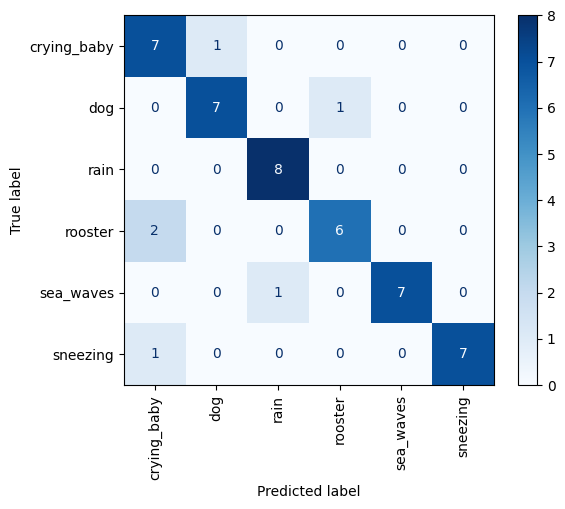

In [82]:
# Carregar o csv contendo os nomes dos arquivos e rótulos do conjunto de teste
csv_teste = pd.read_csv(DIR_DATASET + "teste.csv")

# Extrair as características de todas as gravações do conjunto de teste
X_teste = extrair_caracteristicas_lista(csv_teste['filename'],
                                        DIR_DATASET + "teste/", params_caracteristicas)

# Selecionar as 10 melhores características com base no conjunto de treinamento
X_teste = skb.transform(vt.transform(X_teste))

print(X_teste.shape)

y_teste = csv_teste['category']

# Realizar predições no conjunto de teste
y_pred = classificador.predict(X_teste)

# Exibir o relatório de classificação
print(classification_report(y_teste, y_pred))

# Exibir a matriz de confusão
ConfusionMatrixDisplay.from_estimator(classificador, X_teste, y_teste,
                                      cmap='Blues', xticks_rotation='vertical');